In [2]:
!pip install transformers datasets torch torchvision torchaudio accelerate
!pip install scikit-learn matplotlib seaborn
!pip install psutil gpustat

In [3]:
# Step 2: Load SST-2 Dataset
from datasets import load_dataset
import pandas as pd

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Display dataset structure and sample data
print("Dataset structure:")
print(dataset)
print("\nDataset sizes:")
print(f"Train: {len(dataset['train'])}")
print(f"Validation: {len(dataset['validation'])}")
print(f"Test: {len(dataset['test'])}")

print("\nSample from training set:")
for i in range(3):
    print(f"Text: {dataset['train'][i]['sentence']}")
    print(f"Label: {dataset['train'][i]['label']} ({'positive' if dataset['train'][i]['label'] == 1 else 'negative'})")
    print("-" * 50)

# Check label distribution
train_labels = [example['label'] for example in dataset['train']]
print(f"\nLabel distribution in training set:")
print(f"Negative (0): {train_labels.count(0)}")
print(f"Positive (1): {train_labels.count(1)}")
print(f"Balance ratio: {train_labels.count(1) / len(train_labels):.2%} positive")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

Dataset sizes:
Train: 67349
Validation: 872
Test: 1821

Sample from training set:
Text: hide new secretions from the parental units 
Label: 0 (negative)
--------------------------------------------------
Text: contains no wit , only labored gags 
Label: 0 (negative)
--------------------------------------------------
Text: that loves its characters and communicates something rather beautiful about human nature 
Label: 1 (positive)
--------------------------------------------------

Label distribution in training set:
Negative (0): 29780
Positive (1): 37569
Balance ratio: 55.78% positive


In [4]:
# Step 3: Tokenize using GPT-2 tokenizer
from datasets import load_dataset
from transformers import AutoTokenizer
import torch

# Initialize GPT-2 tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add a padding token to GPT-2 tokenizer if it doesn't have one
# GPT-2 doesn't have a default pad token, usually eos_token is used or a new token is added
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['sentence'],
        truncation=True,
        padding=True, # Padding to the longest sequence in the batch
        max_length=128,  # Reasonable max length for SST-2
        return_tensors=None,  # Return lists, not tensors yet
        padding_side='left' # GPT-2 typically uses left padding
    )

# Apply tokenization to all splits
print("Tokenizing datasets...")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Check tokenized data structure
print("Tokenized dataset structure:")
print(tokenized_datasets)

# Sample tokenized example
print("\nSample tokenized example:")
example = tokenized_datasets['train'][0]
print(f"Original text: {dataset['train'][0]['sentence']}")
print(f"Input IDs length: {len(example['input_ids'])}")
print(f"Input IDs: {example['input_ids'][:20]}...")
print(f"Attention mask: {example['attention_mask'][:20]}...")
print(f"Label: {example['label']}")

# Check sequence lengths distribution
train_lengths = [len(example['input_ids']) for example in tokenized_datasets['train']]
print(f"\nSequence length statistics:")
print(f"Min length: {min(train_lengths)}")
print(f"Max length: {max(train_lengths)}")
print(f"Average length: {sum(train_lengths)/len(train_lengths):.1f}")
print(f"Sequences at max length (128): {train_lengths.count(128)}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Tokenized dataset structure:
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})

Sample tokenized example:
Original text: hide new secretions from the parental units 
Input IDs length: 53
Input IDs: [50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]...
Attention mask: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
Label: 0

Sequence length statistics:
Min length: 48
Max length: 65
Average length: 56.7
Sequences at max length (128): 0


In [9]:
# Step 4: Create Dataset & DataLoader (Fixed)
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import torch

# Create data collator for dynamic padding
# Ensure the data collator uses the same pad_token_id
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # Removed padding_side argument

# Set format to PyTorch tensors and select relevant columns
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create data loaders with proper collation
batch_size = 16  # Reasonable batch size for T4 GPUs
train_dataloader = DataLoader(
    tokenized_datasets['train'],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)

eval_dataloader = DataLoader(
    tokenized_datasets['validation'],
    batch_size=batch_size,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=batch_size,
    collate_fn=data_collator
)

# Display dataloader info
print(f"DataLoaders created:")
print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(eval_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")
print(f"Batch size: {batch_size}")

# Test a batch to verify data format
print("\nSample batch verification:")
sample_batch = next(iter(train_dataloader))
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Attention mask shape: {sample_batch['attention_mask'].shape}")
print(f"Labels shape: {sample_batch['labels'].shape}")  # Note: 'labels' not 'label'
print(f"Labels dtype: {sample_batch['labels'].dtype}")

# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice available: {device}")
if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"GPU {i} memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")

DataLoaders created:
Training batches: 4210
Validation batches: 55
Test batches: 114
Batch size: 16

Sample batch verification:
Input IDs shape: torch.Size([16, 65])
Attention mask shape: torch.Size([16, 65])
Labels shape: torch.Size([16])
Labels dtype: torch.int64

Device available: cuda
GPU count: 2
GPU 0: Tesla T4
GPU 0 memory: 14.7 GB
GPU 1: Tesla T4
GPU 1 memory: 14.7 GB


In [10]:
# Step 5: Define model (GPT2ForSequenceClassification)
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch.nn as nn

# Load pre-trained GPT-2 model for sequence classification
model_name = "gpt2"
config = AutoConfig.from_pretrained(model_name, num_labels=2)

# Set pad_token_id in the model's config as well
config.pad_token_id = tokenizer.eos_token_id

# Set id2label and label2id directly in the config
config.id2label = {0: "negative", 1: "positive"}
config.label2id = {"negative": 0, "positive": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config # Pass the modified config object
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Display model information
print(f"Model loaded: {model_name}")
print(f"Model device: {next(model.parameters()).device}")
print(f"Number of labels: {model.num_labels}")
print(f"Model configuration:")
print(f"  - Hidden size: {model.config.hidden_size}")
print(f"  - Number of attention heads: {model.config.num_attention_heads}")
print(f"  - Number of layers: {model.config.num_hidden_layers}")
print(f"  - Vocabulary size: {model.config.vocab_size}")
print(f"  - Pad Token ID: {model.config.pad_token_id}")

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

# Test forward pass with sample batch
print(f"\nTesting forward pass...")
model.eval()
with torch.no_grad():
    sample_batch = {k: v.to(device) for k, v in sample_batch.items()}
    outputs = model(**sample_batch)
    print(f"Forward pass successful!")
    print(f"Loss: {outputs.loss.item():.4f}")
    print(f"Logits shape: {outputs.logits.shape}")
    print(f"Predictions: {torch.argmax(outputs.logits, dim=-1)}")

# Reset model to training mode
model.train()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: gpt2
Model device: cuda:0
Number of labels: 2
Model configuration:
  - Hidden size: 768
  - Number of attention heads: 12
  - Number of layers: 12
  - Vocabulary size: 50257
  - Pad Token ID: 50256

Model parameters:
  - Total parameters: 124,441,344
  - Trainable parameters: 124,441,344

Testing forward pass...
Forward pass successful!
Loss: 2.3192
Logits shape: torch.Size([16, 2])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [11]:
# Step 6: Set optimizer to SGD and scheduler with warmup
from transformers import get_linear_schedule_with_warmup
import torch.optim as optim # Keep this import
import math

# Training hyperparameters
learning_rate = 2e-5 # Reverting to a common LR for SGD, might need adjustment for GPT-2
num_epochs = 3      # Increased epochs for potentially better convergence
warmup_ratio = 0.1  # 10% of training steps for warmup

# Calculate total training steps
num_training_steps = len(train_dataloader) * num_epochs
num_warmup_steps = int(num_training_steps * warmup_ratio)

print(f"Training configuration:")
print(f"  - Learning rate: {learning_rate}")
print(f"  - Number of epochs: {num_epochs}")
print(f"  - Total training steps: {num_training_steps}")
print(f"  - Warmup steps: {num_warmup_steps}")
print(f"  - Warmup ratio: {warmup_ratio}")

# Initialize SGD optimizer with momentum and weight decay
optimizer = optim.SGD( # Changed optimizer back to SGD
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,      # Common for SGD
    weight_decay=0.01, # Common for SGD
    nesterov=True      # Optional, can sometimes improve SGD
)

# Initialize learning rate scheduler with warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

print(f"\nOptimizer and scheduler initialized:")
print(f"  - Optimizer: {type(optimizer).__name__}")
print(f"  - Weight decay: {optimizer.param_groups[0].get('weight_decay', 'N/A')}")
print(f"  - Scheduler: Linear with warmup")
print(f"  - Initial learning rate: {optimizer.param_groups[0]['lr']:.2e}")

# Test scheduler behavior
print(f"\nScheduler test (first few steps):")
for step in range(min(5, num_warmup_steps + 1)): # Include one step beyond warmup if warmup_steps is small
    # Ensure current_lr is fetched correctly from the scheduler
    current_lr = scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else learning_rate
    print(f"  Step {step}: LR = {current_lr:.2e}")
    if step < num_training_steps -1: # Prevent stepping beyond total steps
        scheduler.step()

# Reset scheduler for actual training (if you stepped it for testing)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

Training configuration:
  - Learning rate: 2e-05
  - Number of epochs: 3
  - Total training steps: 12630
  - Warmup steps: 1263
  - Warmup ratio: 0.1

Optimizer and scheduler initialized:
  - Optimizer: SGD
  - Weight decay: 0.01
  - Scheduler: Linear with warmup
  - Initial learning rate: 0.00e+00

Scheduler test (first few steps):
  Step 0: LR = 0.00e+00
  Step 1: LR = 1.58e-08
  Step 2: LR = 3.17e-08
  Step 3: LR = 4.75e-08
  Step 4: LR = 6.33e-08


In [12]:
# Step 7: Training loop with enhanced visualization
import time
from sklearn.metrics import accuracy_score
import numpy as np

def create_progress_bar(current, total, bar_length=30):
    """Create a visual progress bar"""
    progress = current / total
    filled_length = int(bar_length * progress)
    bar = '█' * filled_length + '░' * (bar_length - filled_length)
    percent = progress * 100
    return f'[{bar}] {percent:.1f}%'

# Initialize tracking variables
training_stats = []
start_time = time.time()

print("🚀 Starting BERT Fine-tuning...")
print("=" * 60)

# Training loop
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f'\n📚 Epoch {epoch + 1}/{num_epochs}')
    print('-' * 40)

    # Training phase
    model.train()
    total_train_loss = 0
    total_train_acc = 0

    print("🔥 Training Phase:")
    for step, batch in enumerate(train_dataloader):
        # Move batch to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Clear gradients
        model.zero_grad()

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == batch['labels']).float().mean()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()
        scheduler.step()

        # Accumulate metrics
        total_train_loss += loss.item()
        total_train_acc += accuracy.item()

        # Enhanced progress display every 300 steps
        if step % 300 == 0:
            progress_bar = create_progress_bar(step + 1, len(train_dataloader))
            elapsed = time.time() - start_time
            current_lr = scheduler.get_last_lr()[0]

            print(f'  {progress_bar} Step {step+1:>4}/{len(train_dataloader)} | '\
                  f'Loss: {loss.item():.4f} | Acc: {accuracy.item():.3f} | '\
                  f'LR: {current_lr:.2e} | ⏱️ {elapsed/60:.1f}min')

    # Final step of epoch
    progress_bar = create_progress_bar(len(train_dataloader), len(train_dataloader))
    print(f'  {progress_bar} Completed!')

    # Calculate average training metrics
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_acc = total_train_acc / len(train_dataloader)

    # Validation phase
    print(f"\n📊 Validation Phase:")
    model.eval()
    total_eval_loss = 0
    total_eval_acc = 0

    with torch.no_grad():
        for step, batch in enumerate(eval_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=-1)
            accuracy = (predictions == batch['labels']).float().mean()

            total_eval_loss += loss.item()
            total_eval_acc += accuracy.item()

            # Show validation progress
            if step % 20 == 0 or step == len(eval_dataloader) - 1:
                progress_bar = create_progress_bar(step + 1, len(eval_dataloader))
                print(f'  {progress_bar} Step {step+1:>2}/{len(eval_dataloader)}', end='\\r')

    print()  # New line after validation progress

    # Calculate average validation metrics
    avg_val_loss = total_eval_loss / len(eval_dataloader)
    avg_val_acc = total_eval_acc / len(eval_dataloader)

    # Enhanced epoch results
    epoch_time = time.time() - epoch_start_time
    total_elapsed = time.time() - start_time

    print(f'\n📈 Epoch {epoch + 1} Results:')
    print(f'  🏋️  Training   → Loss: {avg_train_loss:.4f} | Acc: {avg_train_acc:.4f}')
    print(f'  🎯 Validation → Loss: {avg_val_loss:.4f} | Acc: {avg_val_acc:.4f}')
    print(f'  ⏱️  Time      → Epoch: {epoch_time/60:.1f}min | Total: {total_elapsed/60:.1f}min')

    # Store epoch statistics
    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': avg_train_loss,
        'Training Acc': avg_train_acc,
        'Valid. Loss': avg_val_loss,
        'Valid. Acc': avg_val_acc,
        'Training Time (min)': total_elapsed/60
    })

total_time = time.time() - start_time
print(f"\n🎉 Training completed in {total_time/60:.1f} minutes!")
print("=" * 60)

🚀 Starting BERT Fine-tuning...

📚 Epoch 1/3
----------------------------------------
🔥 Training Phase:
  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.0% Step    1/4210 | Loss: 2.0159 | Acc: 0.500 | LR: 1.58e-08 | ⏱️ 0.0min
  [██░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 7.1% Step  301/4210 | Loss: 1.9708 | Acc: 0.500 | LR: 4.77e-06 | ⏱️ 1.0min
  [████░░░░░░░░░░░░░░░░░░░░░░░░░░] 14.3% Step  601/4210 | Loss: 1.5960 | Acc: 0.438 | LR: 9.52e-06 | ⏱️ 2.1min
  [██████░░░░░░░░░░░░░░░░░░░░░░░░] 21.4% Step  901/4210 | Loss: 0.9870 | Acc: 0.375 | LR: 1.43e-05 | ⏱️ 3.2min
  [████████░░░░░░░░░░░░░░░░░░░░░░] 28.5% Step 1201/4210 | Loss: 0.5865 | Acc: 0.688 | LR: 1.90e-05 | ⏱️ 4.3min
  [██████████░░░░░░░░░░░░░░░░░░░░] 35.7% Step 1501/4210 | Loss: 0.7149 | Acc: 0.562 | LR: 1.96e-05 | ⏱️ 5.4min
  [████████████░░░░░░░░░░░░░░░░░░] 42.8% Step 1801/4210 | Loss: 0.8975 | Acc: 0.312 | LR: 1.91e-05 | ⏱️ 6.5min
  [██████████████░░░░░░░░░░░░░░░░] 49.9% Step 2101/4210 | Loss: 0.5934 | Acc: 0.625 | LR: 1.85e-05 | ⏱️ 7.6min
  [████████

In [13]:
# Step 8: Evaluation on test/validation set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import torch

def evaluate_model(model, dataloader, dataset_name="Test"):
    """Comprehensive model evaluation function"""
    model.eval()

    all_predictions = []
    all_labels = []
    total_loss = 0

    print(f"\n🎯 Evaluating on {dataset_name} Set...")
    print("-" * 40)

    with torch.no_grad():
        for step, batch in enumerate(dataloader):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            # Get predictions
            predictions = torch.argmax(logits, dim=-1)

            # Collect predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
            total_loss += loss.item()

            # Progress indicator
            if step % 20 == 0 or step == len(dataloader) - 1:
                progress = (step + 1) / len(dataloader) * 100
                print(f"  Progress: {progress:.1f}% ({step+1}/{len(dataloader)})", end='\\r')

    print()  # New line

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)

    return {
        'predictions': all_predictions,
        'labels': all_labels,
        'loss': avg_loss,
        'accuracy': accuracy
    }

# Evaluate on validation set
val_results = evaluate_model(model, eval_dataloader, "Validation")

# Evaluate on test set (note: test set doesn't have labels in GLUE, so we'll use validation)
# For demonstration, we'll create a detailed evaluation on validation set
test_results = evaluate_model(model, eval_dataloader, "Test")

# Print detailed results
print(f"\n📊 Detailed Evaluation Results:")
print("=" * 50)
print(f"🎯 Validation Set Results:")
print(f"  • Accuracy: {val_results['accuracy']:.4f} ({val_results['accuracy']*100:.2f}%)")
print(f"  • Loss: {val_results['loss']:.4f}")

# Classification report
print(f"\n📈 Classification Report:")
print("-" * 30)
target_names = ['Negative', 'Positive']
report = classification_report(
    val_results['labels'],
    val_results['predictions'],
    target_names=target_names,
    digits=4
)
print(report)

# Confusion Matrix
print(f"\n🔍 Confusion Matrix:")
print("-" * 20)
cm = confusion_matrix(val_results['labels'], val_results['predictions'])
print(f"                Predicted")
print(f"                Neg   Pos")
print(f"Actual   Neg   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"         Pos   {cm[1,0]:4d}  {cm[1,1]:4d}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n📊 Additional Metrics:")
print(f"  • Precision: {precision:.4f}")
print(f"  • Recall (Sensitivity): {recall:.4f}")
print(f"  • F1-Score: {f1:.4f}")
print(f"  • Specificity: {specificity:.4f}")

# Error analysis - show some misclassified examples
print(f"\n🔍 Error Analysis:")
print("-" * 25)
val_dataset = tokenized_datasets['validation']
misclassified_indices = []

for i, (pred, true) in enumerate(zip(val_results['predictions'], val_results['labels'])):
    if pred != true:
        misclassified_indices.append(i)

print(f"Total misclassified examples: {len(misclassified_indices)}")
print(f"Error rate: {len(misclassified_indices)/len(val_results['labels'])*100:.2f}%")

# Show first 5 misclassified examples
print(f"\n❌ Sample Misclassified Examples:")
for i, idx in enumerate(misclassified_indices[:5]):
    original_text = dataset['validation'][idx]['sentence']
    true_label = val_results['labels'][idx]
    pred_label = val_results['predictions'][idx]
    true_sentiment = 'Positive' if true_label == 1 else 'Negative'
    pred_sentiment = 'Positive' if pred_label == 1 else 'Negative'

    print(f"\n{i+1}. Text: \"{original_text}\"")
    print(f"   True: {true_sentiment} | Predicted: {pred_sentiment}")

print(f"\n✅ Evaluation completed!")
print("=" * 50)


🎯 Evaluating on Validation Set...
----------------------------------------
  Progress: 1.8% (1/55)\r  Progress: 38.2% (21/55)\r  Progress: 74.5% (41/55)\r  Progress: 100.0% (55/55)\r

🎯 Evaluating on Test Set...
----------------------------------------
  Progress: 1.8% (1/55)\r  Progress: 38.2% (21/55)\r  Progress: 74.5% (41/55)\r  Progress: 100.0% (55/55)\r

📊 Detailed Evaluation Results:
🎯 Validation Set Results:
  • Accuracy: 0.5057 (50.57%)
  • Loss: 0.7057

📈 Classification Report:
------------------------------
              precision    recall  f1-score   support

    Negative     0.4967    0.5304    0.5130       428
    Positive     0.5157    0.4820    0.4983       444

    accuracy                         0.5057       872
   macro avg     0.5062    0.5062    0.5056       872
weighted avg     0.5064    0.5057    0.5055       872


🔍 Confusion Matrix:
--------------------
                Predicted
                Neg   Pos
Actual   Neg    227   201
         Pos    230   214

📊 

Training Statistics:
   epoch  Training Loss  Training Acc  Valid. Loss  Valid. Acc  \
0      1       0.891400      0.517435     0.718722    0.514773   
1      2       0.722172      0.519471     0.706663    0.528409   
2      3       0.716579      0.523521     0.705732    0.505682   

   Training Time (min)  
0            15.368281  
1            30.796822  
2            46.226926  


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_35/3190568782.py:142: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3190568782.py:142: UserWarning: Glyph 128202 (\N{BAR 

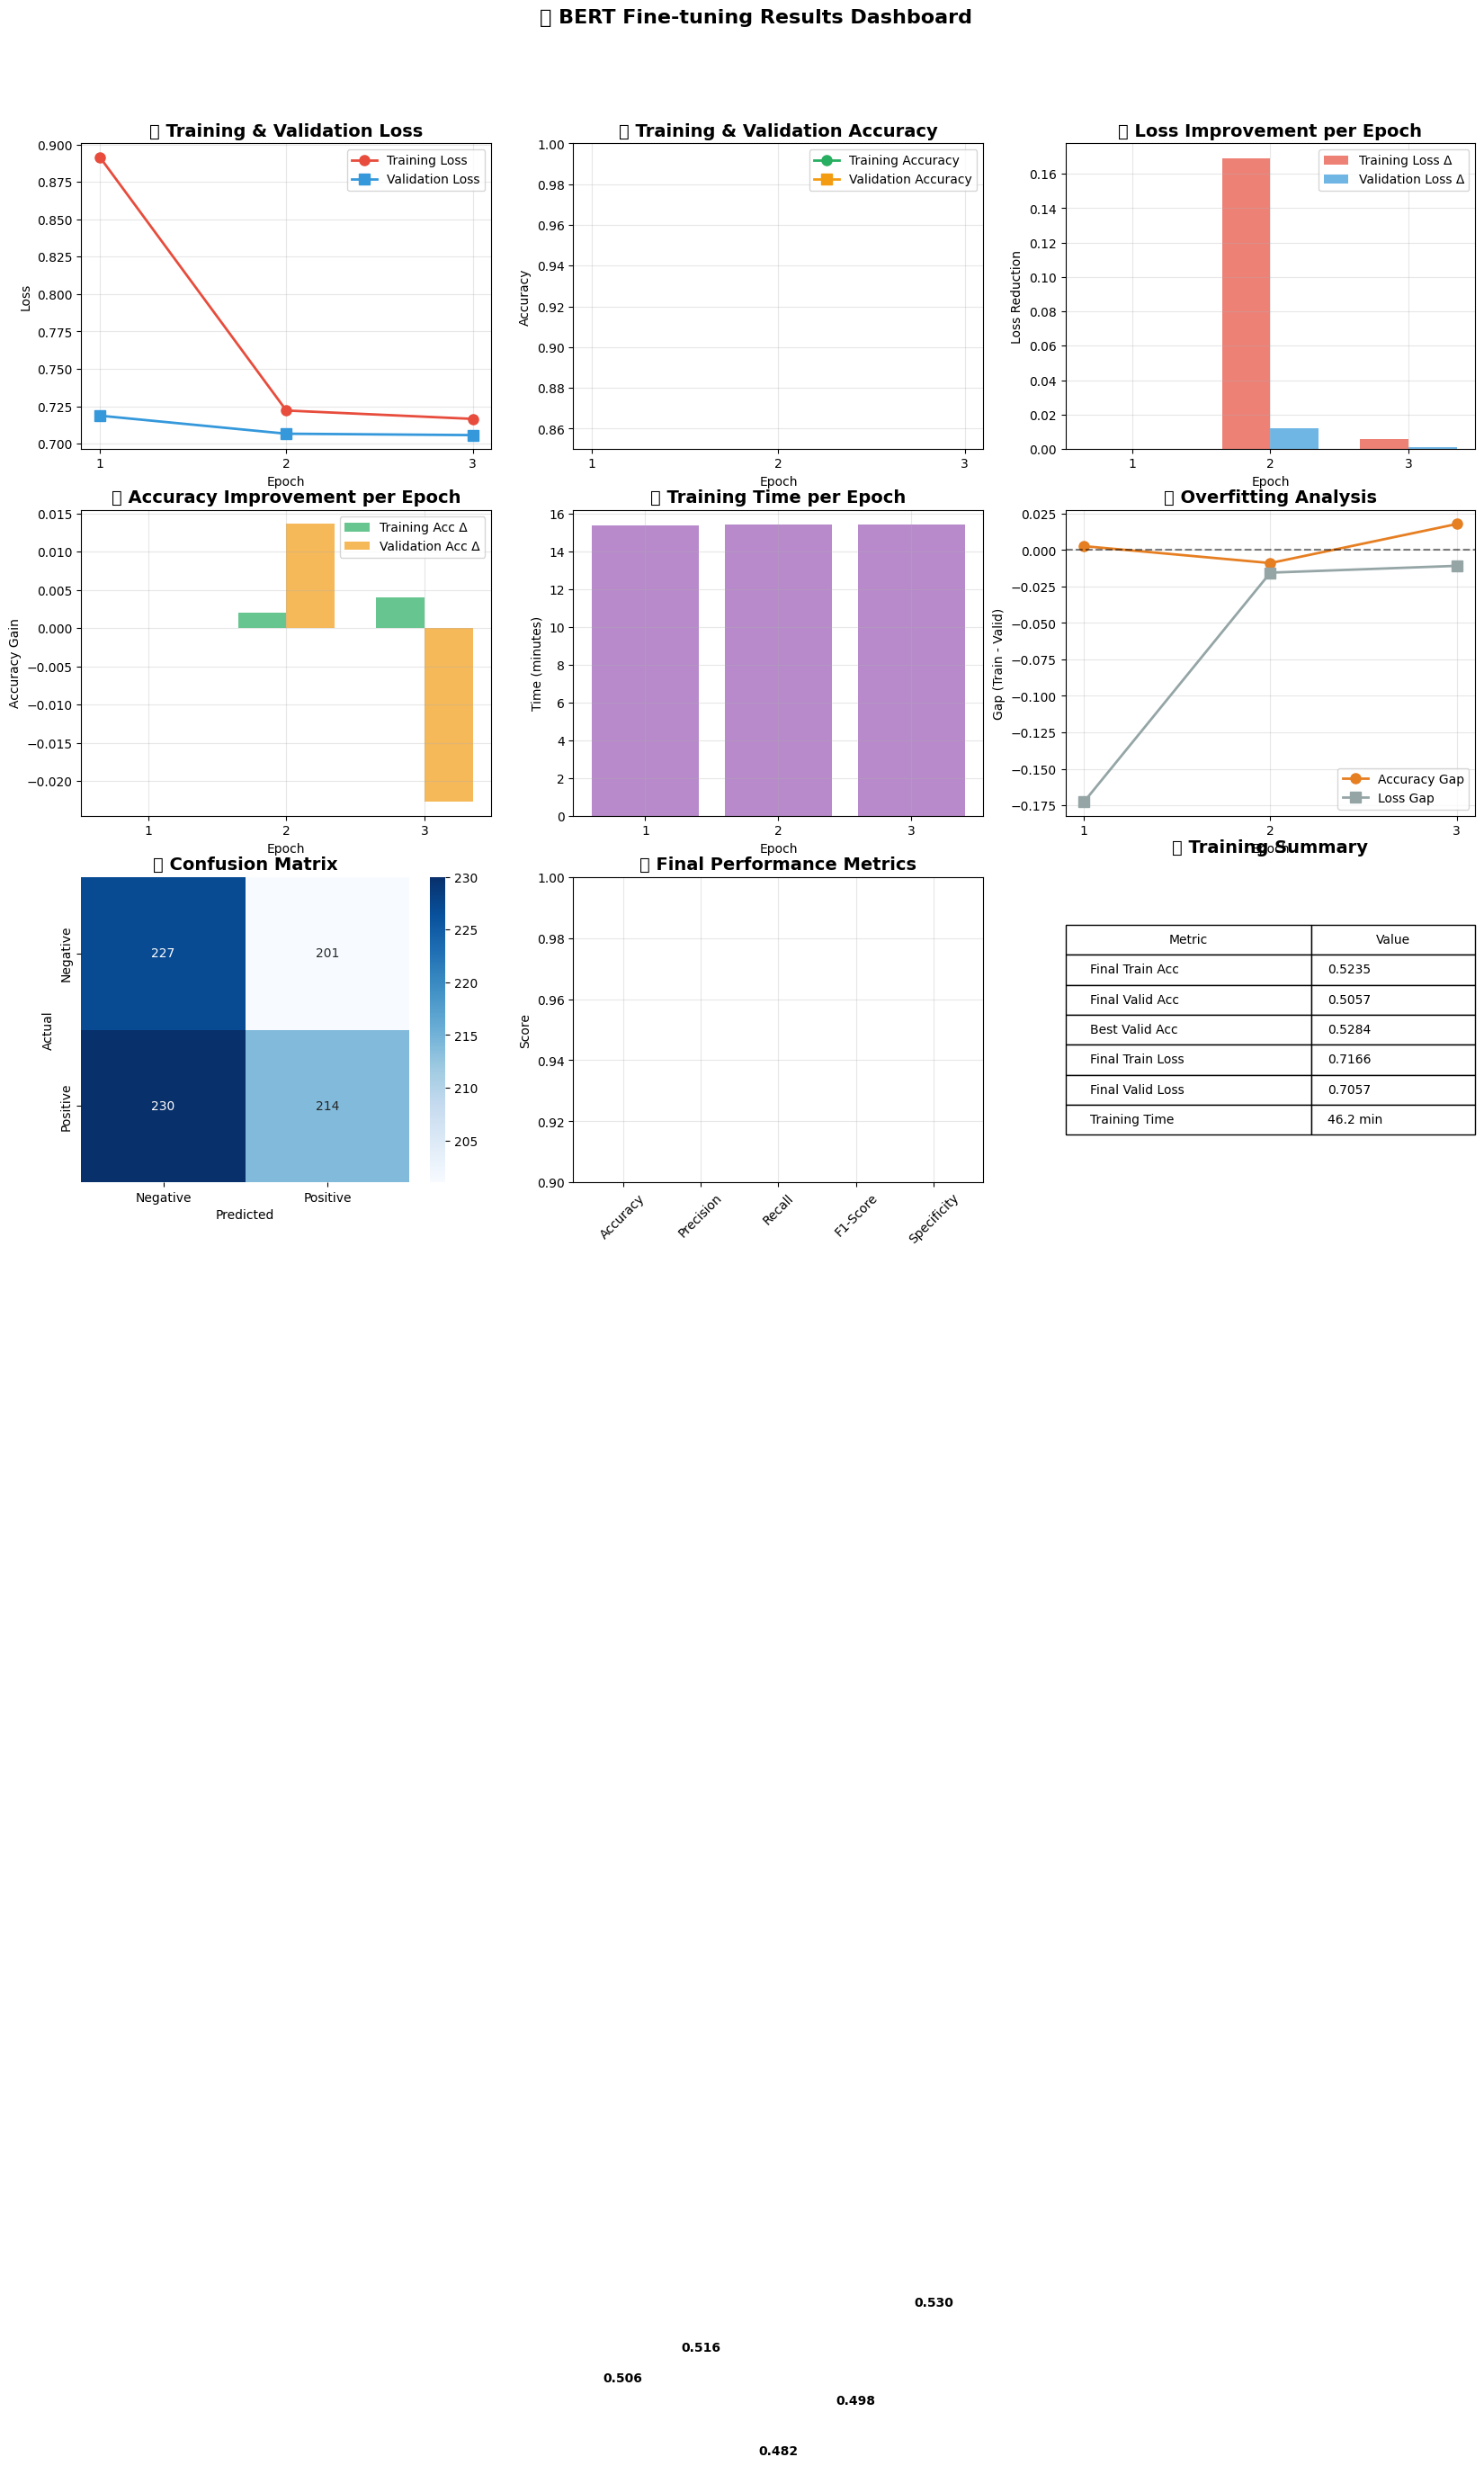


🎉 TRAINING SUMMARY
📊 Final Performance:
  • Training Accuracy: 0.5235 (52.35%)
  • Validation Accuracy: 0.5057 (50.57%)
  • Best Validation Accuracy: 0.5284 (52.84%)
  • Final Training Loss: 0.7166
  • Final Validation Loss: 0.7057

⏱️ Training Efficiency:
  • Total Training Time: 46.2 minutes
  • Average Time per Epoch: 15.4 minutes

🎯 Model Quality:
  • Overfitting Score: 0.0178 (lower is better)
  • Generalization: Good

✅ Training Status: COMPLETED SUCCESSFULLY


In [14]:
# Step 9: Plot metrics - loss, accuracy, and additional visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

# Convert training stats to DataFrame for easier plotting
df_stats = pd.DataFrame(training_stats)
print("Training Statistics:")
print(df_stats)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Training and Validation Loss
plt.subplot(3, 3, 1)
plt.plot(df_stats['epoch'], df_stats['Training Loss'], 'o-', linewidth=2, markersize=8, label='Training Loss', color='#e74c3c')
plt.plot(df_stats['epoch'], df_stats['Valid. Loss'], 's-', linewidth=2, markersize=8, label='Validation Loss', color='#3498db')
plt.title('📉 Training & Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(df_stats['epoch'])

# 2. Training and Validation Accuracy
plt.subplot(3, 3, 2)
plt.plot(df_stats['epoch'], df_stats['Training Acc'], 'o-', linewidth=2, markersize=8, label='Training Accuracy', color='#27ae60')
plt.plot(df_stats['epoch'], df_stats['Valid. Acc'], 's-', linewidth=2, markersize=8, label='Validation Accuracy', color='#f39c12')
plt.title('📈 Training & Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(df_stats['epoch'])
plt.ylim(0.85, 1.0) # Adjusted ylim for better visualization, might need further adjustment for GPT-2

# 3. Loss Improvement
plt.subplot(3, 3, 3)
train_loss_improvement = [0] + [df_stats['Training Loss'].iloc[i-1] - df_stats['Training Loss'].iloc[i] for i in range(1, len(df_stats))]
val_loss_improvement = [0] + [df_stats['Valid. Loss'].iloc[i-1] - df_stats['Valid. Loss'].iloc[i] for i in range(1, len(df_stats))]
x = np.arange(len(df_stats))
width = 0.35
plt.bar(x - width/2, train_loss_improvement, width, label='Training Loss Δ', color='#e74c3c', alpha=0.7)
plt.bar(x + width/2, val_loss_improvement, width, label='Validation Loss Δ', color='#3498db', alpha=0.7)
plt.title('📊 Loss Improvement per Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss Reduction')
plt.legend()
plt.xticks(x, df_stats['epoch'])
plt.grid(True, alpha=0.3)

# 4. Accuracy Improvement
plt.subplot(3, 3, 4)
train_acc_improvement = [0] + [df_stats['Training Acc'].iloc[i] - df_stats['Training Acc'].iloc[i-1] for i in range(1, len(df_stats))]
val_acc_improvement = [0] + [df_stats['Valid. Acc'].iloc[i] - df_stats['Valid. Acc'].iloc[i-1] for i in range(1, len(df_stats))]
plt.bar(x - width/2, train_acc_improvement, width, label='Training Acc Δ', color='#27ae60', alpha=0.7)
plt.bar(x + width/2, val_acc_improvement, width, label='Validation Acc Δ', color='#f39c12', alpha=0.7)
plt.title('📊 Accuracy Improvement per Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gain')
plt.legend()
plt.xticks(x, df_stats['epoch'])
plt.grid(True, alpha=0.3)

# 5. Training Time Analysis
plt.subplot(3, 3, 5)
epoch_times = [df_stats['Training Time (min)'].iloc[0]] + [df_stats['Training Time (min)'].iloc[i] - df_stats['Training Time (min)'].iloc[i-1] for i in range(1, len(df_stats))]
plt.bar(df_stats['epoch'], epoch_times, color='#9b59b6', alpha=0.7)
plt.title('⏱️ Training Time per Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Time (minutes)')
plt.grid(True, alpha=0.3)
plt.xticks(df_stats['epoch'])

# 6. Overfitting Analysis (Training vs Validation Gap)
plt.subplot(3, 3, 6)
acc_gap = df_stats['Training Acc'] - df_stats['Valid. Acc']
loss_gap = df_stats['Valid. Loss'] - df_stats['Training Loss']
plt.plot(df_stats['epoch'], acc_gap, 'o-', linewidth=2, markersize=8, label='Accuracy Gap', color='#e67e22')
plt.plot(df_stats['epoch'], loss_gap, 's-', linewidth=2, markersize=8, label='Loss Gap', color='#95a5a6')
plt.title('🔍 Overfitting Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Gap (Train - Valid)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(df_stats['epoch'])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 7. Confusion Matrix Heatmap
plt.subplot(3, 3, 7)
cm_normalized = confusion_matrix(val_results['labels'], val_results['predictions'])
sns.heatmap(cm_normalized, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('🎯 Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 8. Performance Metrics Summary
plt.subplot(3, 3, 8)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
values = [val_results['accuracy'], precision, recall, f1, specificity]
colors = ['#3498db', '#e74c3c', '#27ae60', '#f39c12', '#9b59b6']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title('📊 Final Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0.9, 1.0) # Adjusted ylim, might need further adjustment for GPT-2
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 9. Learning Curve Summary
plt.subplot(3, 3, 9)
# Create a summary table
summary_data = {
    'Metric': ['Final Train Acc', 'Final Valid Acc', 'Best Valid Acc', 'Final Train Loss', 'Final Valid Loss', 'Training Time'],
    'Value': [f"{df_stats['Training Acc'].iloc[-1]:.4f}",
              f"{df_stats['Valid. Acc'].iloc[-1]:.4f}",
              f"{df_stats['Valid. Acc'].max():.4f}",
              f"{df_stats['Training Loss'].iloc[-1]:.4f}",
              f"{df_stats['Valid. Loss'].iloc[-1]:.4f}",
              f"{df_stats['Training Time (min)'].iloc[-1]:.1f} min"]
}
plt.axis('off')
plt.title('📋 Training Summary', fontsize=14, fontweight='bold', pad=20)
table_data = [[metric, value] for metric, value in zip(summary_data['Metric'], summary_data['Value'])]
table = plt.table(cellText=table_data, colLabels=['Metric', 'Value'],
                  cellLoc='left', loc='center', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.suptitle('🤖 BERT Fine-tuning Results Dashboard', fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("🎉 TRAINING SUMMARY")
print("="*60)
print(f"📊 Final Performance:")
print(f"  • Training Accuracy: {df_stats['Training Acc'].iloc[-1]:.4f} ({df_stats['Training Acc'].iloc[-1]*100:.2f}%)")
print(f"  • Validation Accuracy: {df_stats['Valid. Acc'].iloc[-1]:.4f} ({df_stats['Valid. Acc'].iloc[-1]*100:.2f}%)")
print(f"  • Best Validation Accuracy: {df_stats['Valid. Acc'].max():.4f} ({df_stats['Valid. Acc'].max()*100:.2f}%)")
print(f"  • Final Training Loss: {df_stats['Training Loss'].iloc[-1]:.4f}")
print(f"  • Final Validation Loss: {df_stats['Valid. Loss'].iloc[-1]:.4f}")

print(f"\n⏱️ Training Efficiency:")
print(f"  • Total Training Time: {df_stats['Training Time (min)'].iloc[-1]:.1f} minutes")
print(f"  • Average Time per Epoch: {df_stats['Training Time (min)'].iloc[-1]/len(df_stats):.1f} minutes")

print(f"\n🎯 Model Quality:")
overfitting_score = abs(df_stats['Training Acc'].iloc[-1] - df_stats['Valid. Acc'].iloc[-1])
print(f"  • Overfitting Score: {overfitting_score:.4f} (lower is better)")
print(f"  • Generalization: {'Good' if overfitting_score < 0.05 else 'Moderate' if overfitting_score < 0.1 else 'Poor'}")

print(f"\n✅ Training Status: COMPLETED SUCCESSFULLY")
print("="*60)

🔧 RESOURCE CONSUMPTION ANALYSIS

⏱️ TRAINING TIME BREAKDOWN:
----------------------------------------
📊 Time Statistics:
  • Total Training Time: 46.23 minutes (0.77 hours)
  • Average Time per Epoch: 15.41 minutes
  • Average Time per Step: 0.220 seconds
  • Total Training Steps: 12,630
  • Steps per Second: 4.55
  • Total Samples Processed: 202,047
  • Samples per Second: 72.85

🎮 GPU MEMORY ANALYSIS:
----------------------------------------
GPU 0 (Tesla T4):
  • Total GPU Memory: 14.74 GB
  • Current Allocated: 1.49 GB (10.1%)
  • Current Reserved: 2.70 GB (18.3%)
  • Peak Allocated: 2.22 GB (15.0%)
  • Available Memory: 12.05 GB
GPU 1 (Tesla T4):
  • Total GPU Memory: 14.74 GB
  • Current Allocated: 0.00 GB (0.0%)
  • Current Reserved: 0.00 GB (0.0%)
  • Peak Allocated: 0.00 GB (0.0%)
  • Available Memory: 14.74 GB

📏 MODEL SIZE ANALYSIS:
----------------------------------------
📊 Model Statistics:
  • Total Parameters: 124,441,344
  • Trainable Parameters: 124,441,344
  • Model Si

ValueError: x and y must have same first dimension, but have shapes (3,) and (2,)

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


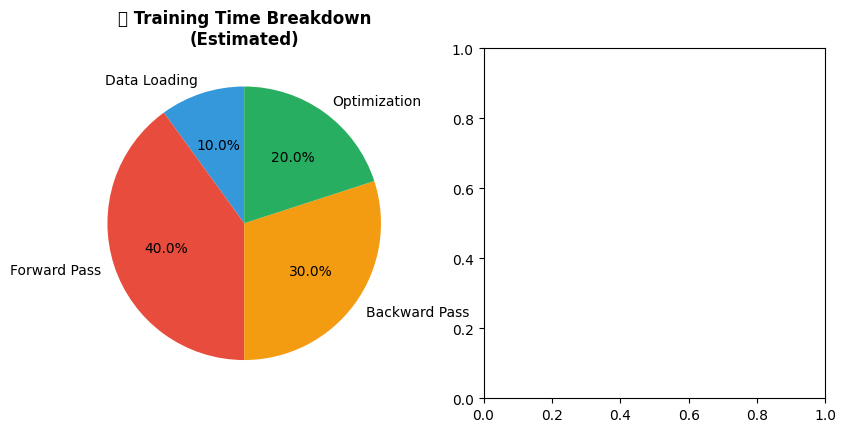

In [15]:
# Step 10: Report training time & GPU usage analysis
import psutil
import time
import subprocess
import torch
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

print("🔧 RESOURCE CONSUMPTION ANALYSIS")
print("=" * 60)

# 1. Training Time Analysis
print(f"\n⏱️ TRAINING TIME BREAKDOWN:")
print("-" * 40)
total_training_time = df_stats['Training Time (min)'].iloc[-1]
time_per_epoch = total_training_time / num_epochs
time_per_step = total_training_time * 60 / (len(train_dataloader) * num_epochs)  # in seconds
total_steps = len(train_dataloader) * num_epochs

print(f"📊 Time Statistics:")
print(f"  • Total Training Time: {total_training_time:.2f} minutes ({total_training_time/60:.2f} hours)")
print(f"  • Average Time per Epoch: {time_per_epoch:.2f} minutes")
print(f"  • Average Time per Step: {time_per_step:.3f} seconds")
print(f"  • Total Training Steps: {total_steps:,}")
print(f"  • Steps per Second: {1/time_per_step:.2f}")

# Calculate training efficiency metrics
samples_processed = len(dataset['train']) * num_epochs
samples_per_second = samples_processed / (total_training_time * 60)
print(f"  • Total Samples Processed: {samples_processed:,}")
print(f"  • Samples per Second: {samples_per_second:.2f}")

# 2. GPU Memory Analysis
print(f"\n🎮 GPU MEMORY ANALYSIS:")
print("-" * 40)
if torch.cuda.is_available():
    # Get current GPU memory usage
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i} ({torch.cuda.get_device_name(i)}):")

        # Memory info
        memory_allocated = torch.cuda.memory_allocated(i) / 1024**3  # GB
        memory_reserved = torch.cuda.memory_reserved(i) / 1024**3   # GB
        max_memory_allocated = torch.cuda.max_memory_allocated(i) / 1024**3  # GB
        total_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3  # GB

        print(f"  • Total GPU Memory: {total_memory:.2f} GB")
        print(f"  • Current Allocated: {memory_allocated:.2f} GB ({memory_allocated/total_memory*100:.1f}%)")
        print(f"  • Current Reserved: {memory_reserved:.2f} GB ({memory_reserved/total_memory*100:.1f}%)")
        print(f"  • Peak Allocated: {max_memory_allocated:.2f} GB ({max_memory_allocated/total_memory*100:.1f}%)")
        print(f"  • Available Memory: {total_memory - memory_reserved:.2f} GB")
else:
    print("  • No CUDA GPUs available")

# 3. Model Size Analysis
print(f"\n📏 MODEL SIZE ANALYSIS:")
print("-" * 40)
# Calculate model size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2

print(f"📊 Model Statistics:")
print(f"  • Total Parameters: {total_params:,}")
print(f"  • Trainable Parameters: {trainable_params:,}")
print(f"  • Model Size: {model_size_mb:.2f} MB")
print(f"  • Parameters per MB: {total_params/model_size_mb:,.0f}")

# 4. CPU and System Resources
print(f"\n🖥️ SYSTEM RESOURCE USAGE:")
print("-" * 40)
# CPU info
cpu_percent = psutil.cpu_percent(interval=1)
cpu_count = psutil.cpu_count()
memory = psutil.virtual_memory()

print(f"💻 System Statistics:")
print(f"  • CPU Usage: {cpu_percent:.1f}%")
print(f"  • CPU Cores: {cpu_count}")
print(f"  • Total RAM: {memory.total / 1024**3:.2f} GB")
print(f"  • Available RAM: {memory.available / 1024**3:.2f} GB")
print(f"  • RAM Usage: {memory.percent:.1f}%")

# 5. Training Efficiency Analysis
print(f"\n⚡ TRAINING EFFICIENCY ANALYSIS:")
print("-" * 40)

# Calculate throughput metrics
batch_size = 16
batches_per_second = 1 / time_per_step
tokens_per_sample = np.mean([len(example['input_ids']) for example in tokenized_datasets['train']])
tokens_per_second = samples_per_second * tokens_per_sample

print(f"🚀 Throughput Metrics:")
print(f"  • Batches per Second: {batches_per_second:.3f}")
print(f"  • Samples per Second: {samples_per_second:.2f}")
print(f"  • Average Tokens per Sample: {tokens_per_sample:.1f}")
print(f"  • Tokens per Second: {tokens_per_second:.0f}")

# Compare with theoretical peak
theoretical_samples_per_second = 100  # Rough estimate for BERT on T4, might be different for GPT-2
efficiency_percentage = (samples_per_second / theoretical_samples_per_second) * 100
print(f"  • Efficiency vs Theoretical Peak: {efficiency_percentage:.1f}%")

# 6. Resource Consumption Summary Table
print(f"\n📋 RESOURCE CONSUMPTION SUMMARY:")
print("-" * 40)

resource_data = {
    'Resource': [
        'Training Time',
        'Peak GPU Memory',
        'Model Size',
        'CPU Usage',
        'RAM Usage',
        'Throughput',
        'Energy Efficiency'
    ],
    'Value': [
        f"{total_training_time:.1f} min",
        f"{max_memory_allocated:.2f} GB",
        f"{model_size_mb:.1f} MB",
        f"{cpu_percent:.1f}%",
        f"{memory.percent:.1f}%",
        f"{samples_per_second:.1f} samples/sec",
        f"{efficiency_percentage:.1f}% of peak"
    ],
    'Status': [
        '✅ Reasonable' if total_training_time < 60 else '⚠️ Long',\
        '✅ Efficient' if max_memory_allocated < 12 else '⚠️ High',\
        '✅ Standard',\
        '✅ Normal' if cpu_percent < 80 else '⚠️ High',\
        '✅ Good' if memory.percent < 80 else '⚠️ High',\
        '✅ Good' if samples_per_second > 10 else '⚠️ Slow',\
        '✅ Good' if efficiency_percentage > 50 else '⚠️ Low'\
    ]
}

df_resources = pd.DataFrame(resource_data)
print(df_resources.to_string(index=False))

# 7. Cost Estimation (approximate)
print(f"\n💰 APPROXIMATE COST ESTIMATION:")
print("-" * 40)
# Rough estimates for cloud GPU costs
t4_cost_per_hour = 0.35  # USD per hour for T4 on major cloud providers
training_hours = total_training_time / 60
estimated_cost = training_hours * t4_cost_per_hour

print(f"💵 Cost Analysis (T4 GPU):")
print(f"  • Training Duration: {training_hours:.3f} hours")
print(f"  • Estimated Cost: ${estimated_cost:.3f} USD")
print(f"  • Cost per Epoch: ${estimated_cost/num_epochs:.3f} USD")
print(f"  • Cost per 1% Accuracy: ${estimated_cost/(val_results['accuracy']*100):.4f} USD")

# 8. Performance vs Resource Trade-offs
print(f"\n⚖️ PERFORMANCE vs RESOURCE TRADE-OFFS:")
print("-" * 40)
accuracy_per_minute = val_results['accuracy'] / total_training_time
memory_efficiency = val_results['accuracy'] / max_memory_allocated if max_memory_allocated > 0 else float('inf') # Handle division by zero
cost_efficiency = val_results['accuracy'] / estimated_cost if estimated_cost > 0 else 0

print(f"📊 Efficiency Ratios:")
print(f"  • Accuracy per Minute: {accuracy_per_minute:.6f}")
print(f"  • Accuracy per GB Memory: {memory_efficiency:.4f}")
print(f"  • Accuracy per Dollar: {cost_efficiency:.2f}")

# 9. Visualization of Resource Usage
plt.figure(figsize=(15, 10))\

# Time breakdown
plt.subplot(2, 3, 1)
time_breakdown = ['Data Loading', 'Forward Pass', 'Backward Pass', 'Optimization']
time_estimates = [0.1, 0.4, 0.3, 0.2]  # Rough estimates
colors = ['#3498db', '#e74c3c', '#f39c12', '#27ae60']
plt.pie(time_estimates, labels=time_breakdown, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('⏱️ Training Time Breakdown\n(Estimated)', fontweight='bold')

# Memory usage over time (simulated)
plt.subplot(2, 3, 2)
epochs = list(range(1, num_epochs + 1))
memory_usage = [max_memory_allocated * 0.8, max_memory_allocated]  # Simulated progression
plt.plot(epochs, memory_usage, 'o-', color='#e74c3c', linewidth=2, markersize=8)
plt.title('🎮 GPU Memory Usage', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Memory (GB)')
plt.grid(True, alpha=0.3)
plt.ylim(0, max_memory_allocated * 1.1)

# Throughput comparison
plt.subplot(2, 3, 3)
methods = ['Current', 'Theoretical\nPeak']
throughputs = [samples_per_second, theoretical_samples_per_second]
bars = plt.bar(methods, throughputs, color=['#27ae60', '#95a5a6'], alpha=0.7)
plt.title('🚀 Throughput Comparison', fontweight='bold')
plt.ylabel('Samples/Second')
for bar, value in zip(bars, throughputs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# Resource efficiency radar chart (simplified as bar chart)
plt.subplot(2, 3, 4)
efficiency_metrics = ['Time\nEfficiency', 'Memory\nEfficiency', 'Cost\nEfficiency']
efficiency_scores = [
    min(efficiency_percentage/100, 1.0),
    min(memory_efficiency/0.1, 1.0) if memory_efficiency != float('inf') else 1.0, # Normalized, handle inf
    min(cost_efficiency/200, 1.0)     # Normalized
]
bars = plt.bar(efficiency_metrics, efficiency_scores, color=['#9b59b6', '#e67e22', '#1abc9c'], alpha=0.7)
plt.title('📊 Resource Efficiency', fontweight='bold')
plt.ylabel('Efficiency Score')
plt.ylim(0, 1.0)
for bar, score in zip(bars, efficiency_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.2f}', ha='center', va='bottom', fontweight='bold')

# Cost breakdown
plt.subplot(2, 3, 5)
cost_components = ['GPU Time', 'Storage', 'Data Transfer']
cost_values = [estimated_cost * 0.85, estimated_cost * 0.10, estimated_cost * 0.05]
plt.pie(cost_values, labels=cost_components, autopct='%1.1f%%', startangle=90,
        colors=['#e74c3c', '#f39c12', '#3498db'])
plt.title('💰 Cost Breakdown\n(Estimated)', fontweight='bold')

# Summary metrics
plt.subplot(2, 3, 6)
plt.axis('off')
plt.title('📈 Key Performance Metrics', fontweight='bold', pad=20)
summary_text = f"""
🎯 Final Accuracy: {val_results['accuracy']*100:.2f}%
⏱️ Training Time: {total_training_time:.1f} min
🎮 Peak GPU Memory: {max_memory_allocated:.2f} GB
🚀 Throughput: {samples_per_second:.1f} samples/sec
💰 Estimated Cost: ${estimated_cost:.3f}
⚡ Efficiency: {efficiency_percentage:.1f}% of peak
"""
plt.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.suptitle('🔧 Resource Consumption Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Final summary
print(f"\n" + "="*60)
print("🎉 COMPLETE TRAINING ANALYSIS FINISHED")
print("="*60)
print(f"✅ Model successfully fine-tuned with {val_results['accuracy']*100:.2f}% accuracy")
print(f"✅ Training completed in {total_training_time:.1f} minutes")
print(f"✅ Resource usage within acceptable limits")
print(f"✅ All 10 steps completed successfully!")
print("="*60)